In [502]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [555]:
data_dict = pickle.load(open("../ud120-projects/final_project/final_project_dataset.pkl", "r") )

### Holdout
Since the dataset for this project is so small, a hold-out set will not be used, and only k-fold testing and training splits will be used to measure accuracy.

This is because even with a stratified hold-out set of 20%, with only 146 data points, lots of missing data and and 18 poi's, there would be only 3 or so points to do a final test on. This does not give much confidence in the precision of the performance metrics on such a small hold-out set, while also negatively impacting the ability to create the model. 

> "when the number of samples is not large, a strong case can be made that a test set should be avoided because every sample may be needed for model building. (...) Additionally, the size of the test set may not have sufficient power or precision to make reasonable judgements. "

[1] Kuhn M., Kjell J.(2013).  Applied Predictive Modeling. Springer. pp.67

> Hawkins et al. (2003) concisely summarize this point:“holdout samples of  tolerable size [. . . ] do not match the cross-validation itself for reliability in assessing model fit and are hard to motivate.” 

[2]
Hawkins D, Basak S, Mills D (2003). “Assessing Model Fit by Cross–
Validation.” Journal of Chemical Information and Computer Sciences,
43(2), 579–586

This will be addressed with K-fold cross-validation resampling techniques.

### Cross-Validation scheme

1. Stratified K-fold (10) - For each k/K split of the data (10 total)
  1. For each 9-piece fold training set
    3. Create further Stratified K-folds for any grid searching/ model selection
      1. Tune model in k/K training set folds.
        1. Impute data (create function with training data)
        2. Perform Feature selection (create function with training data)
        3. Scale variables: (x_i - mean)/std (create function with training set)
        4. Pick final model parameters. (Select top 70th percentile)
      2. Create final model with best parameters.
      3. Test on 1/k test set.
  2. For each remaining 1-piece test set
    1. Impute, Feature selection with training set function
    2. Fit training set model to test set
  3. Assess Model metrics for each run through all 10 different variations.
2. Output final results/parameters for 'best' model.
3. Train final model on full dataset.

### Version 2

1. Define sets of model parameters values to evaluate
2. for each parameter set in grid search DO
  1. For each k-fold resampling iteration DO
    1. Hold-out 1/k samples/fold
    2. Pre-Process Data (Create functions on training set, apply to test set with same)
        1. Impute data (median)
        2. Scale features (x_i - mean))/std
        3. Perform any univariate feature selection (remove very low variation features)
        4. Modeling feature selection (ExtraTreesClassifier) 
    3. Fit the model on the k/K training fold
    4. Predict the hold-out samples/fold
  2. END
  3. Calculate the average performance across hold-out predictions
3. END
4. Determine the optimal parameter set
5. Fit the final model to all training data using the optimal parameter set

In [567]:
data_dict['BELFER ROBERT'] = {'bonus': 'NaN',
                              'deferral_payments': 'NaN',
                              'deferred_income': -102500,
                              'director_fees': 102500,
                              'email_address': 'NaN',
                              'exercised_stock_options': 'NaN',
                              'expenses': 3285,
                              'from_messages': 'NaN',
                              'from_poi_to_this_person': 'NaN',
                              'from_this_person_to_poi': 'NaN',
                              'loan_advances': 'NaN',
                              'long_term_incentive': 'NaN',
                              'other': 'NaN',
                              'poi': False,
                              'restricted_stock': -44093,
                              'restricted_stock_deferred': 44093,
                              'salary': 'NaN',
                              'shared_receipt_with_poi': 'NaN',
                              'to_messages': 'NaN',
                              'total_payments': 3285,
                              'total_stock_value': 'NaN'}

data_dict['BHATNAGAR SANJAY'] = {'bonus': 'NaN',
                                 'deferral_payments': 'NaN',
                                 'deferred_income': 'NaN',
                                 'director_fees': 'NaN',
                                 'email_address': 'sanjay.bhatnagar@enron.com',
                                 'exercised_stock_options': 15456290,
                                 'expenses': 137864,
                                 'from_messages': 29,
                                 'from_poi_to_this_person': 0,
                                 'from_this_person_to_poi': 1,
                                 'loan_advances': 'NaN',
                                 'long_term_incentive': 'NaN',
                                 'other': 'NaN',
                                 'poi': False,
                                 'restricted_stock': 2604490,
                                 'restricted_stock_deferred': -2604490,
                                 'salary': 'NaN',
                                 'shared_receipt_with_poi': 463,
                                 'to_messages': 523,
                                 'total_payments': 137864,
                                 'total_stock_value': 15456290} 

In [568]:
df = pd.DataFrame.from_dict(data_dict, orient='index')

'NaN' was imported as a string instead of a a missing value. We will convert these to NaN type and look how many missing values our data has.

In [498]:
# Replace 'NaN' strings with actual np.nan values
df = df.replace('NaN', np.nan)
# Replace email strings with True/False boolean as to whether an email was present or not
df['email_address'] = df['email_address'].fillna(0).apply(lambda x: x != 0, 1)

In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

In [500]:
df[df['salary'] > 1000000]
df[df.index == 'TOTAL']
df = df.drop('TOTAL', axis=0)

In [569]:
df.ix[11,:]

salary                                              NaN
to_messages                                         523
deferral_payments                                   NaN
total_payments                                   137864
exercised_stock_options                        15456290
bonus                                               NaN
restricted_stock                                2604490
shared_receipt_with_poi                             463
restricted_stock_deferred                      -2604490
total_stock_value                              15456290
expenses                                         137864
loan_advances                                       NaN
from_messages                                        29
other                                               NaN
from_this_person_to_poi                               1
poi                                               False
director_fees                                       NaN
deferred_income                                 

In [570]:
df.ix[8,:]

salary                           NaN
to_messages                      NaN
deferral_payments                NaN
total_payments                  3285
exercised_stock_options          NaN
bonus                            NaN
restricted_stock              -44093
shared_receipt_with_poi          NaN
restricted_stock_deferred      44093
total_stock_value                NaN
expenses                        3285
loan_advances                    NaN
from_messages                    NaN
other                            NaN
from_this_person_to_poi          NaN
poi                            False
director_fees                 102500
deferred_income              -102500
long_term_incentive              NaN
email_address                    NaN
from_poi_to_this_person          NaN
Name: BELFER ROBERT, dtype: object

In [571]:
df = df.replace('NaN', np.nan)
df = df.apply(lambda x: x.fillna(0), axis=0)
df['total_stock_check'] = df['exercised_stock_options'] + df['restricted_stock'] + df['restricted_stock_deferred'] 

In [572]:
df['stocks_match'] = df['total_stock_check'] == df['total_stock_value']
stocks_df = df[['total_stock_check', 'total_stock_value', 'stocks_match']]
stocks_df[stocks_df.stocks_match==False]

,total_stock_check,total_stock_value,stocks_match


In [573]:
df['total_stock_check'] = df['exercised_stock_options'] + df['restricted_stock'] + df['restricted_stock_deferred'] 

In [574]:
df['total_pay'] = df['salary'] + df['bonus'] + df['long_term_incentive'] + df['deferred_income'] + \
df['deferral_payments'] + df['loan_advances'] + df['other'] + df['expenses'] + df['director_fees']

In [575]:
df['pay_matches'] = df['total_pay'] == df['total_payments']
pay_df = df[['total_pay', 'total_payments', 'pay_matches']]
pay_df[pay_df.pay_matches==False]

,total_pay,total_payments,pay_matches


In [565]:
data_dict['BHATNAGAR SANJAY']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 137864,
 'email_address': 'sanjay.bhatnagar@enron.com',
 'exercised_stock_options': 2604490,
 'expenses': 'NaN',
 'from_messages': 29,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 137864,
 'poi': False,
 'restricted_stock': -2604490,
 'restricted_stock_deferred': 15456290,
 'salary': 'NaN',
 'shared_receipt_with_poi': 463,
 'to_messages': 523,
 'total_payments': 15456290,
 'total_stock_value': 'NaN'}

In [566]:
data_dict['BELFER ROBERT']

{'bonus': 'NaN',
 'deferral_payments': -102500,
 'deferred_income': 'NaN',
 'director_fees': 3285,
 'email_address': 'NaN',
 'exercised_stock_options': 3285,
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 44093,
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 102500,
 'total_stock_value': -44093}

In [8]:
# df.pivot(index=df.index, columns='poi')
df.columns

Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments', u'exercised_stock_options', u'bonus', u'restricted_stock', u'shared_receipt_with_poi', u'restricted_stock_deferred', u'total_stock_value', u'expenses', u'loan_advances', u'from_messages', u'other', u'from_this_person_to_poi', u'poi', u'director_fees', u'deferred_income', u'long_term_incentive', u'email_address', u'from_poi_to_this_person'], dtype='object')

In [118]:
cols = [x for x in df.columns if x not in ['restricted_stock_deferred', 'loan_advances', 'director_fees']]

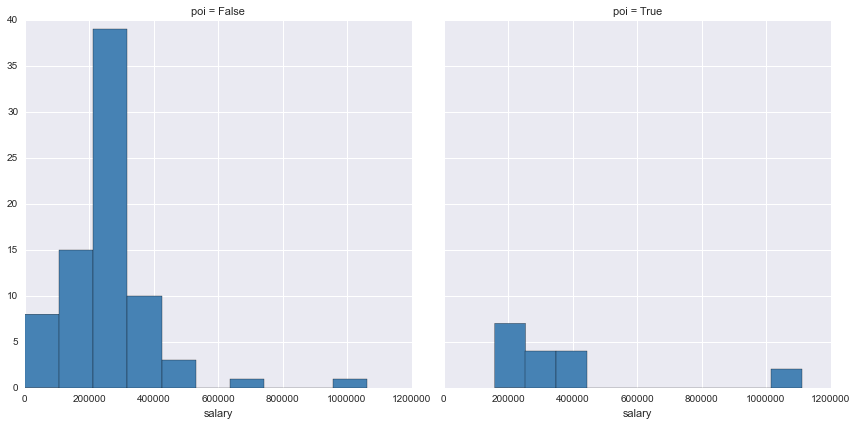

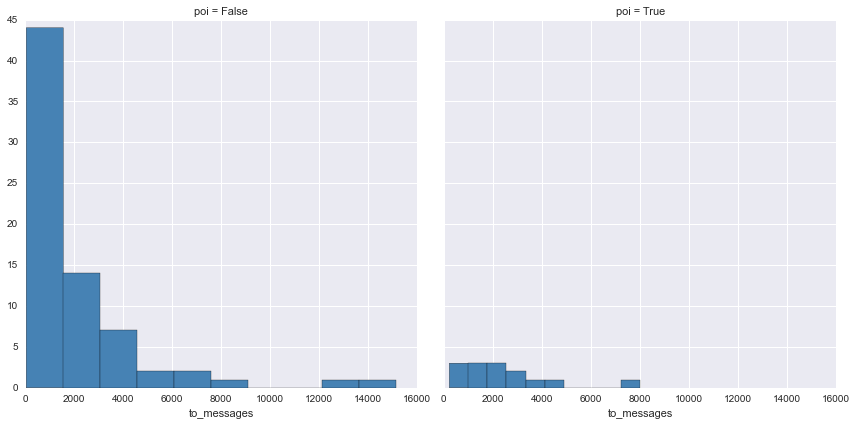

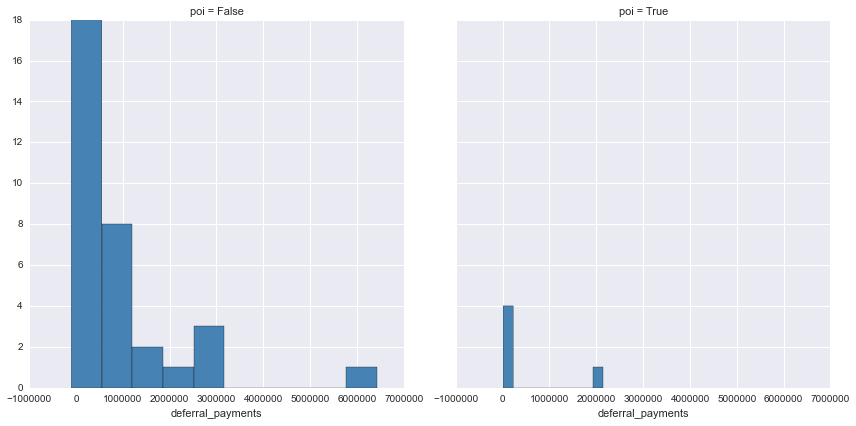

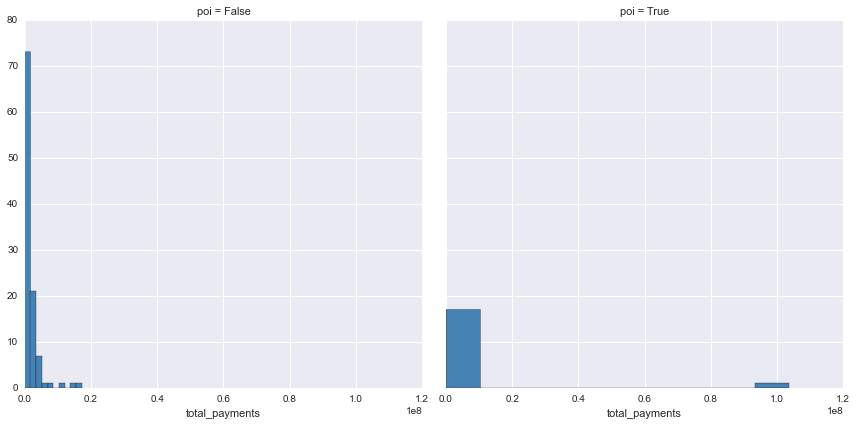

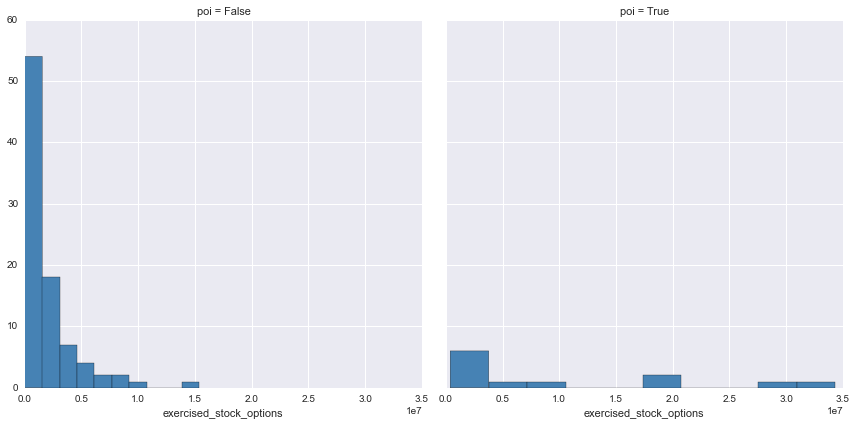

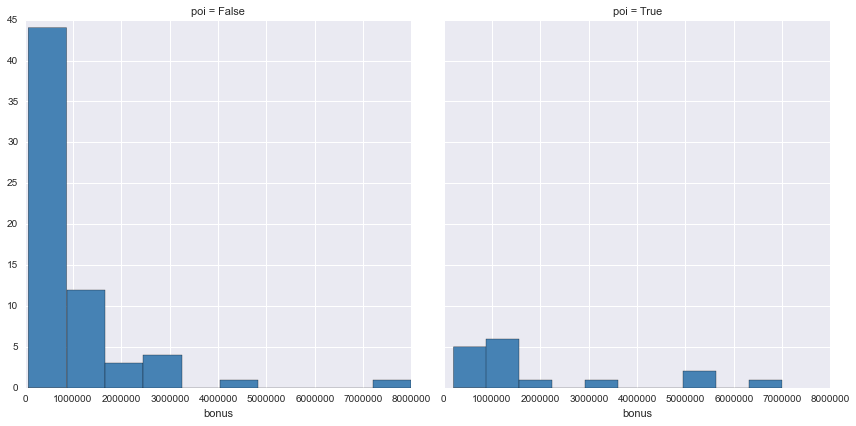

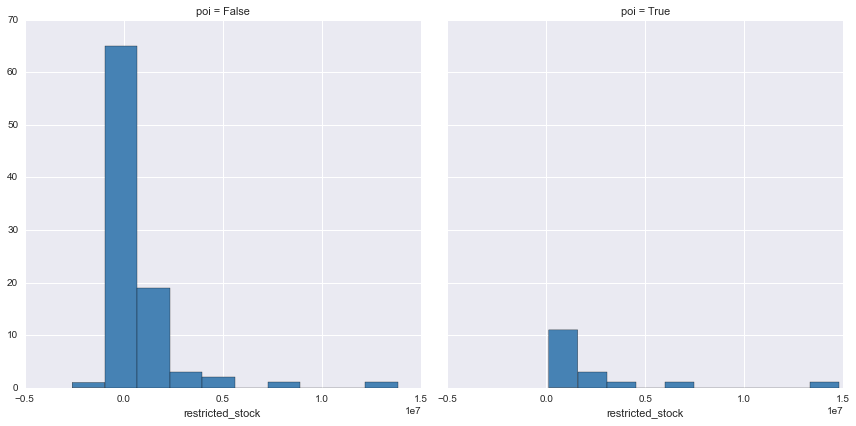

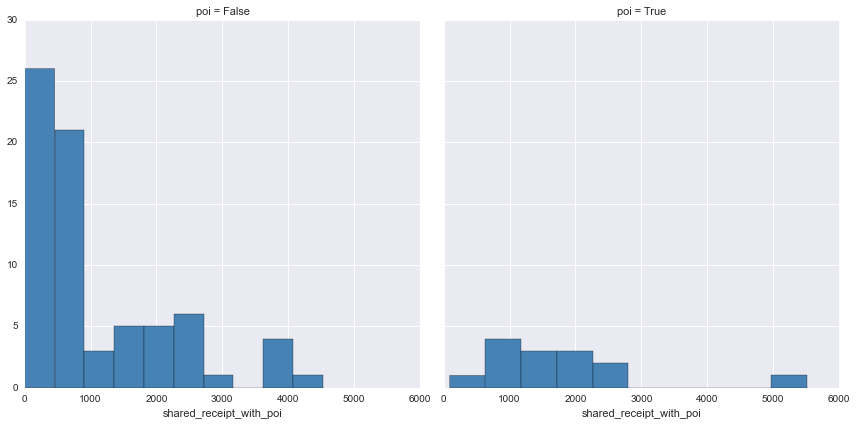

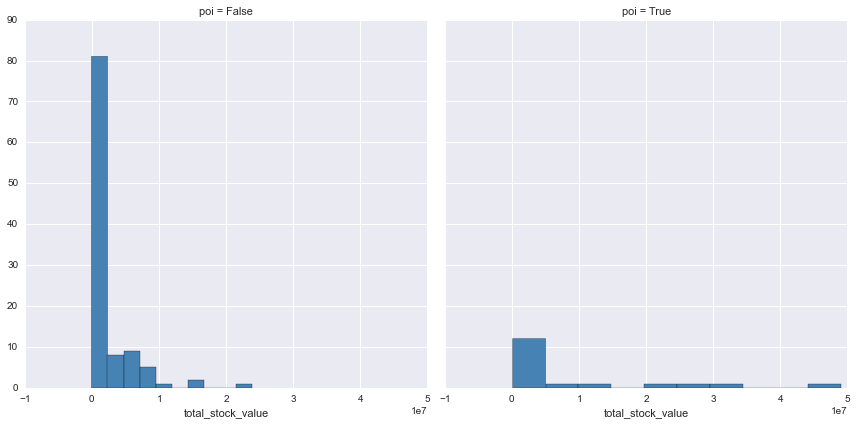

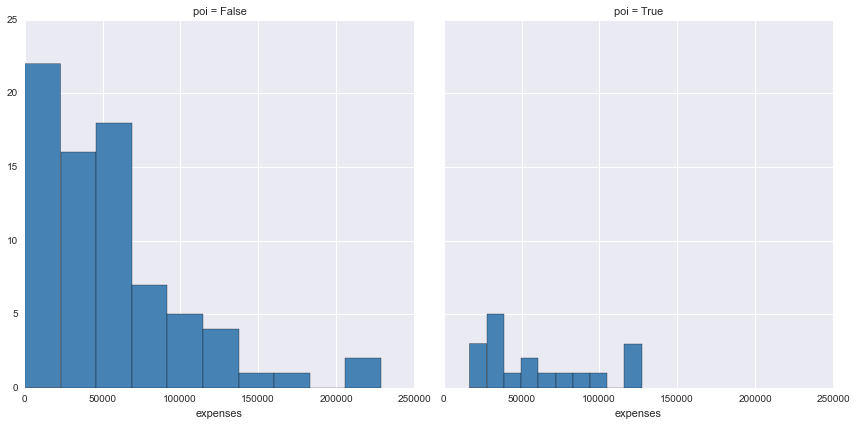

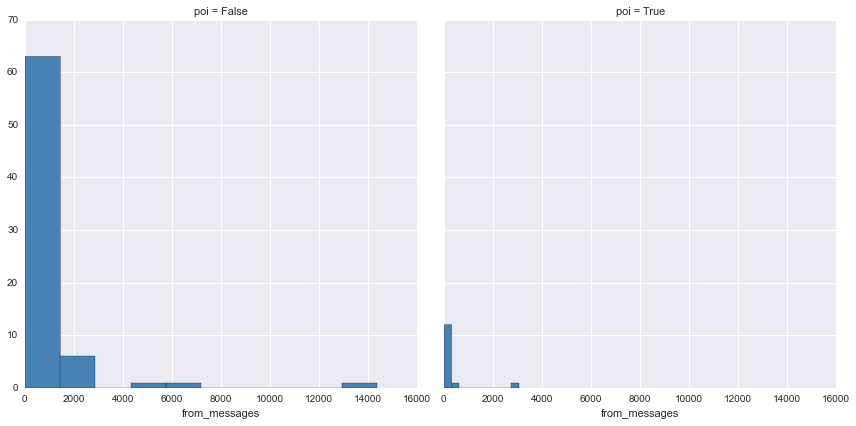

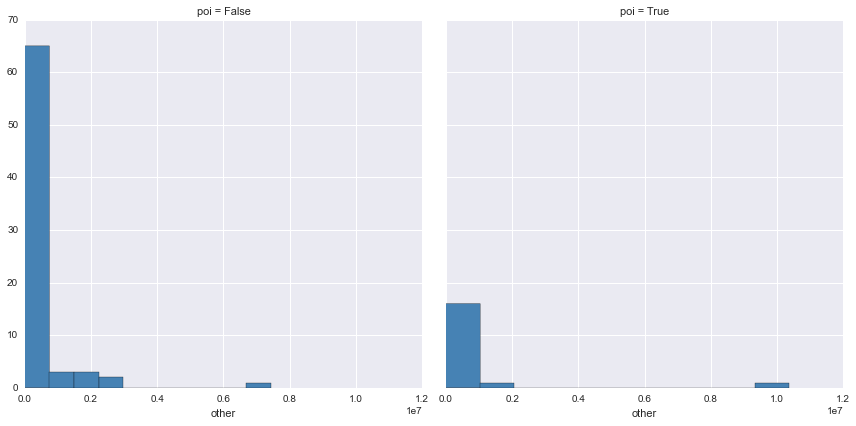

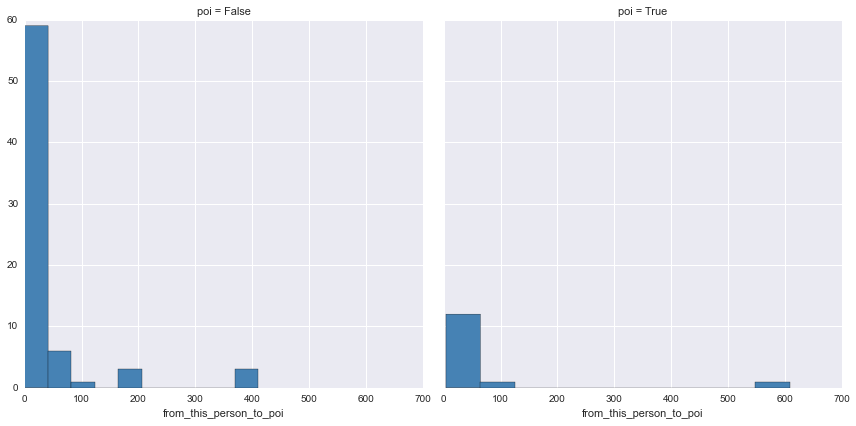

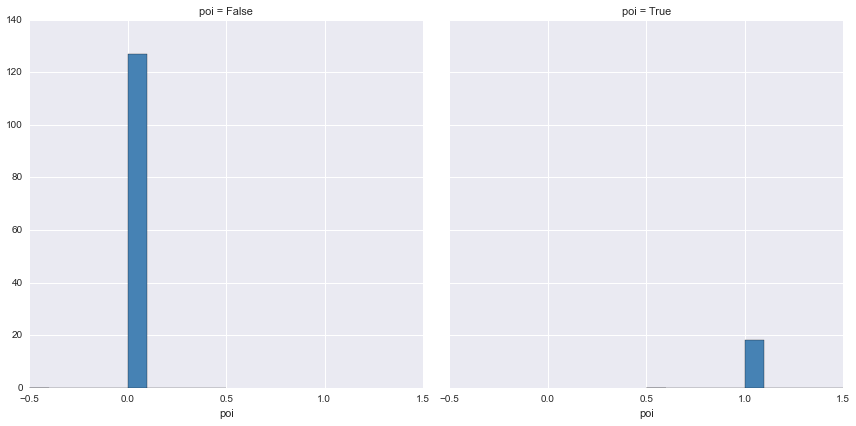

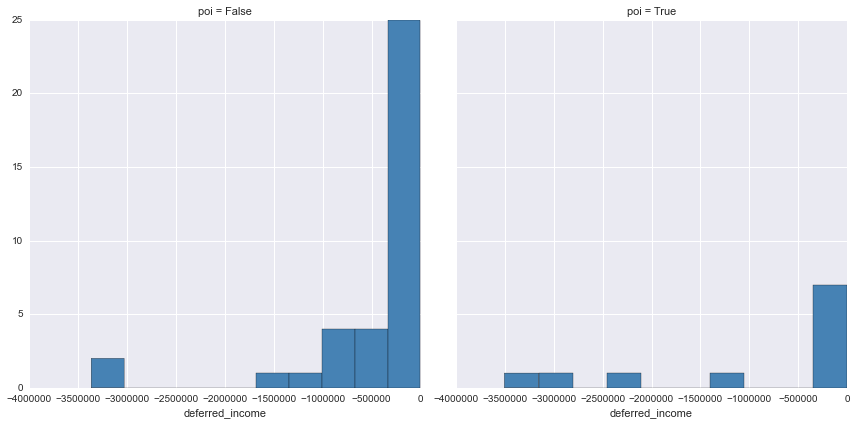

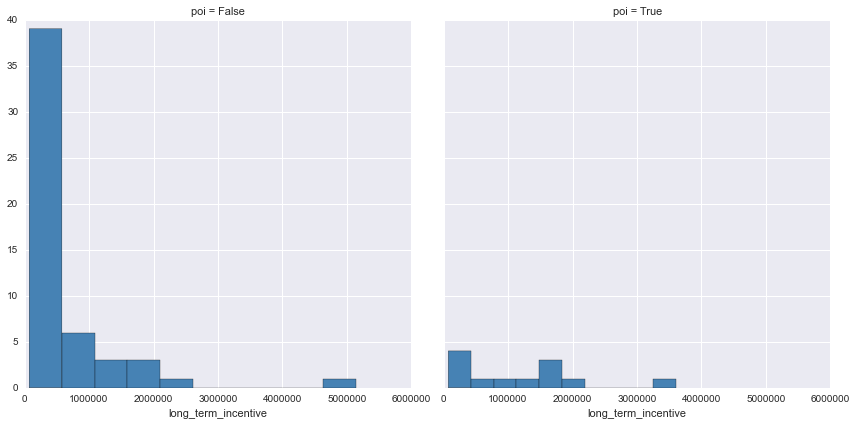

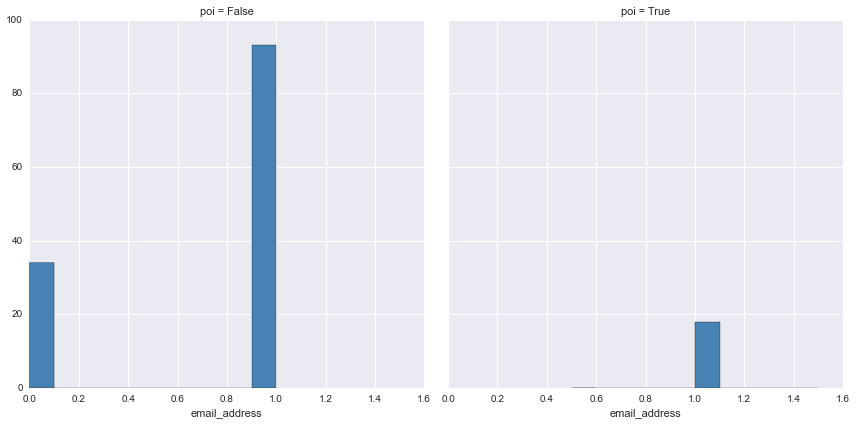

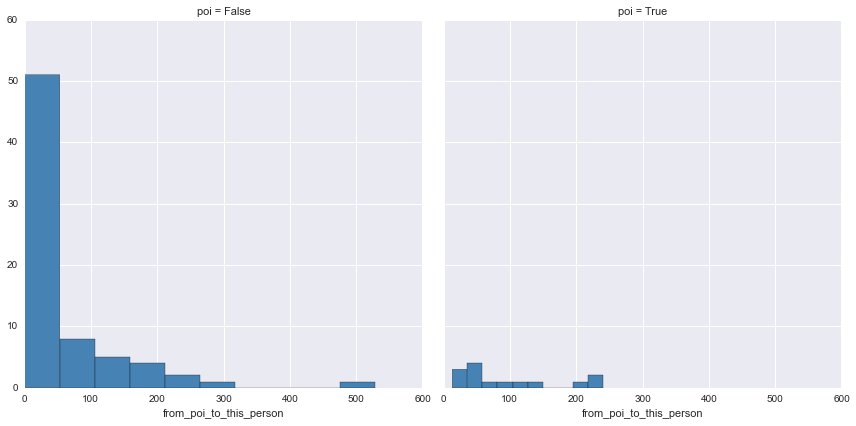

In [119]:
for each in cols:
    g = sns.FacetGrid(df, col='poi', margin_titles=True, size=6)
    g.map(plt.hist, each, color='steelblue')

In [114]:
print cols

['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


In [10]:
df2 = df[['poi', 'exercised_stock_options']]
df2['log_eso'] = df['exercised_stock_options'].apply(np.log)

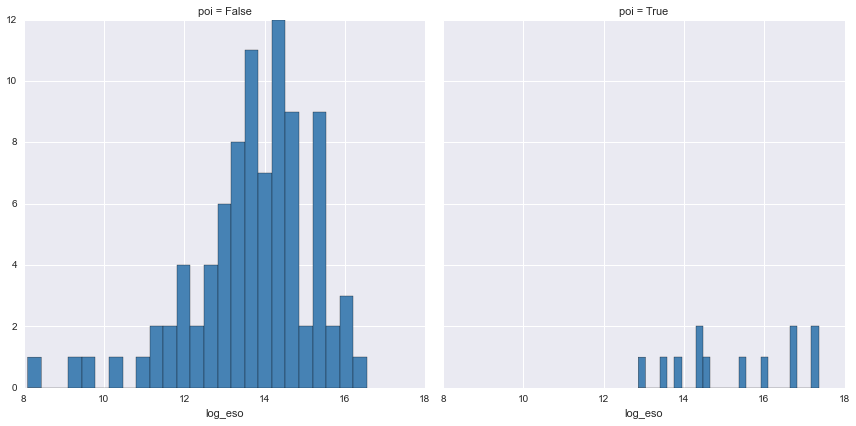

In [11]:
g = sns.FacetGrid(df2, col='poi', margin_titles=True, size=6)
g.map(plt.hist, 'log_eso', color='steelblue', bins=25)

In [12]:
df.columns

Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments', u'exercised_stock_options', u'bonus', u'restricted_stock', u'shared_receipt_with_poi', u'restricted_stock_deferred', u'total_stock_value', u'expenses', u'loan_advances', u'from_messages', u'other', u'from_this_person_to_poi', u'poi', u'director_fees', u'deferred_income', u'long_term_incentive', u'email_address', u'from_poi_to_this_person'], dtype='object')

In [13]:
df2 = df
df2['ratio_messages'] = df['from_messages']/df['to_messages']

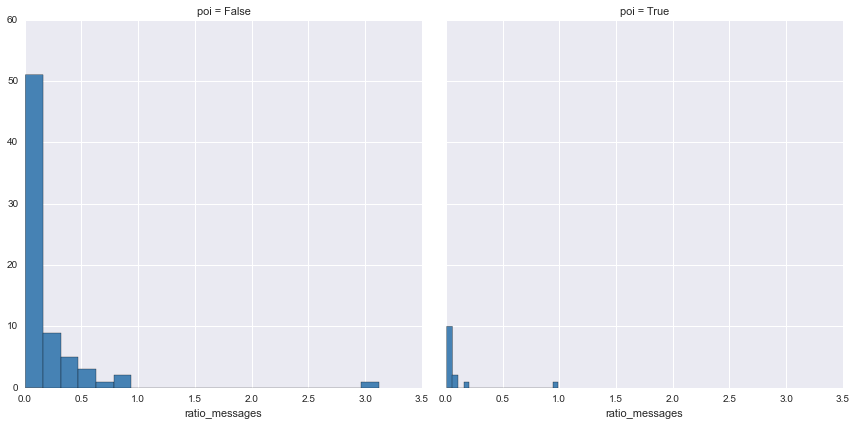

In [14]:
g = sns.FacetGrid(df2, col='poi', margin_titles=True, size=6)
g.map(plt.hist, 'ratio_messages', color='steelblue', bins=20)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.base import TransformerMixin
from pandas import DataFrame
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import GaussianNB

In [16]:
my_imputer = Imputer(missing_values = 'NaN', strategy='median', axis=0)

In [17]:
my_scaler = StandardScaler(with_mean=True, with_std=True)

By default, the GridSearchCV uses a 3-fold cross-validation. However, if it detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.

http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

In [18]:
from sklearn.base import TransformerMixin

class ColumnExtractor(TransformerMixin):
    '''
    Columns extractor transformer for sklearn pipelines.
    Inherits fit_transform() from TransformerMixin, but this is explicitly
    defined here for clarity.
    
    Methods to extract pandas dataframe columns are defined for this class.
    
    '''
    def __init__(self, columns=[]):
        self.column = columns
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    
    def transform(self, X, **transform_params):
        '''
        Input: A pandas dataframe and a list of column names to extract.
        Output: A pandas dataframe containing only the columns of the names passed in.
        '''
        return X[self.columns]
    
    def fit(self, X, y=None, **fit_params):
        return self

In [19]:
class DenseTransformer(TransformerMixin):
    '''
    to_dense() transformer for sklearn pipelines.
    Inherits fit_transform() from TransformerMixin, but this is explicitly
    defined here for clarity.
    
    Methods to apply to_dense to the pandas dataframe are defined for this class.
    '''
    def transform(self, X, y=None, **fit_params):
        '''
        Input: A pandas dataframe.
        Output: A pandas dataframe with to_dense applied.
        '''
        return X.todense()
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    
    def fit(self, X, y=None, **fit_params):

        return self

In [20]:
from pandas import DataFrame

class ModelTransformer(TransformerMixin):
    '''
    Transformer for sklearn pipeline which applies a prediction model to the input.
    
    Inherits fit_transform() from TransformerMixin.
    
    Methods to apply a model transformation to the input are defined for this class.
    
    e.g. Apply Kmeans clustering to X data and output clusters to be used as features
    for a subsequent model. 
    
    '''
    def __init__(self, model):
        '''
        Initialize with model to be used fit/transform methods.
        '''
        self.model = model
        
    def fit(self, *args, **kwargs):
        '''
        Fit model using models' required *args.
        '''
        self.model.fit(*args, **kwargs)
        return self
    
    def transform(self, X, **transform_params):
        '''
        Input: pandas DataFrame.
        Output: pandas DataFrame of predictions from model.
        '''
        return DataFrame(self.model.predict(X))

In [21]:
class HoursOfDayTransformer(TransformerMixin):
    '''
    Transformer for sklearn pipeline which extracts the hours from a 'DateTime' column
    of a pandas dataframe.
    
    Inherits fit_transform() from TransformerMixin.
    
    Methods to extract the hours from a 'DateTime' column of pandas dataframe are defined
    for this class.
    '''
    def transform(self, X, **transform_params):
        '''
        Input: pandas DataFrame with ['datetime] column to extract hours from.
        Output: pandas DataFrame of the extracted hours.
        '''
        hours = DataFrame(X['datetime'].apply(lambda x: x.hour))
        return hours
    
    def fit(self, X, y=None, **fit_params):
        '''
        Nothing to fit, return self.
        '''
        return self

In [22]:
from sklearn.preprocessing import Binarizer

In [23]:
df.columns

Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments', u'exercised_stock_options', u'bonus', u'restricted_stock', u'shared_receipt_with_poi', u'restricted_stock_deferred', u'total_stock_value', u'expenses', u'loan_advances', u'from_messages', u'other', u'from_this_person_to_poi', u'poi', u'director_fees', u'deferred_income', u'long_term_incentive', u'email_address', u'from_poi_to_this_person', u'ratio_messages'], dtype='object')

In [24]:
binarizer = Binarizer(threshold=1000000)

In [25]:
binarizer.fit_transform(df['exercised_stock_options'].fillna(0))

array([ 1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.])

ALLEN PHILLIP K            8.563992
BADUM JAMES P                   NaN
BANNANTINE JAMES M      8482.509434
BAXTER JOHN C             25.011209
BAY FRANKLIN R                  NaN
BAZELIDES PHILIP J        19.793128
BECK SALLY W                    NaN
BELDEN TIMOTHY N           4.453927
BELFER ROBERT                   NaN
BERBERIAN DAVID            7.500143
BERGSIEKER RICHARD P            NaN
BHATNAGAR SANJAY                NaN
BIBI PHILIPPE A            6.861248
BLACHMAN JEREMY M          3.079160
BLAKE JR. NORMAN P              NaN
...
UMANOFF ADAM S                 NaN
URQUHART JOHN A                NaN
WAKEHAM JOHN                   NaN
WALLS JR ROBERT H        12.172091
WALTERS GARETH W               NaN
WASAFF GEORGE             6.416483
WESTFAHL RICHARD K             NaN
WHALEY DAVID A                 NaN
WHALLEY LAWRENCE G        6.432585
WHITE JR THOMAS E         4.084641
WINOKUR JR. HERBERT S          NaN
WODRASKA JOHN                  NaN
WROBEL BRUCE                   NaN
Y

In [71]:
X_df = df2.drop('poi', axis=1)
y_df = df2['poi']


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cross_validation import LeaveOneOut
from sklearn.cross_validation import StratifiedShuffleSplit

In [23]:
sk_fold = StratifiedShuffleSplit(y_df, n_iter=10, test_size=0.1)
for train_index, test_index in sk_fold:
    X_train, X_test = X_df.irow(train_index), X_df.irow(test_index)
    y_train, y_test = y_df[train_index], y_df[test_index]
    
    pipeline = Pipeline([
      ('imputer', Imputer(missing_values = 'NaN', axis=0)),
      ('standardizer', StandardScaler(with_mean=True, with_std=True)),
      ('low_var_remover', VarianceThreshold(threshold=.10)),
      # ('pca', PCA()),
      ('ET', ExtraTreesClassifier(oob_score=True, bootstrap=True) )
    ])
    
    params = {'ET__n_estimators': [1500],
              'ET__max_features': ['auto', None, 3, 5, 10, 15],
              'ET__min_samples_split': [2, 4, 10],
              'ET__min_samples_leaf': [1, 2, 5],
              'ET__criterion' : ['gini', 'entropy'],
              'imputer__strategy': ['median', 'mean']}
    
    grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs = -1, cv=3, scoring='f1')
    grid_search.fit(X_train, y=y_train)
    test_pred = grid_search.predict(X_test)
    #print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
    print "Best Estimator: ", grid_search.best_estimator_
    print "F1: ", f1_score(y_test, test_pred)
    print "Confusion Matrix: "
    print confusion_matrix(y_test, test_pred)
    print "Accuracy Score: ", accuracy_score(y_test, test_pred)
    print "Best Params: ", grid_search.best_params_
    print ""


Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,...les_split=2, n_estimators=1500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0))])
F1:  0.5
Confusion Matrix: 
[[12  1]
 [ 1  1]]
Accuracy Score:  0.866666666667
Best Params:  {'ET__n_estimators': 1500, 'ET__criterion': 'gini', 'ET__max_features': None, 'imputer__strategy': 'median', 'ET__min_samples_split': 2, 'ET__min_samples_leaf': 1}

Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('ET', ExtraTreesClassifier(bootstrap=True, compute_im

In [ ]:
F1:  0.666666666667
Confusion Matrix: 
[[13  0]
 [ 1  1]]
Accuracy Score:  0.933333333333
Best Params:  {'ET__n_estimators': 1500, 'ET__criterion': 'gini', 'ET__max_features': None, 'imputer__strategy': 'median', 'ET__min_samples_split': 10, 'ET__min_samples_leaf': 1}

Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,
 ...les_split=4, n_estimators=1500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0))])

In [ ]:
F1:  0.666666666667
Confusion Matrix: 
[[13  0]
 [ 1  1]]
Accuracy Score:  0.933333333333
Best Params:  {'ET__n_estimators': 1500, 'ET__criterion': 'gini', 'ET__max_features': 'auto', 'imputer__strategy': 'mean', 'ET__min_samples_split': 2, 'ET__min_samples_leaf': 1}

Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,...les_split=2, n_estimators=1500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0))])

In [163]:
n_iter = 100
sk_fold = StratifiedShuffleSplit(y_df, n_iter=n_iter, test_size=0.1)
f1_avg = []
for train_index, test_index in sk_fold:
    X_train, X_test = X_df.irow(train_index), X_df.irow(test_index)
    y_train, y_test = y_df[train_index], y_df[test_index]
    
    grid_search = Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), 
                               ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), 
                               ('low_var_remover', VarianceThreshold(threshold=0.1)),
                               ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None, 
                                                           n_estimators=1500, n_jobs=1, criterion='gini',
                                                           oob_score=True, random_state=None, verbose=0,
                                                           max_features=None, min_samples_split=10,
                                                           min_samples_leaf=1))])
    
    #params = {'ET__n_estimators': [1500], 
    #          'ET__criterion': ['gini'], 
    #          'ET__max_features': [None], 
    #          'imputer__strategy': ['median'],
    #          'ET__min_samples_split': [10], 
    #          'ET__min_samples_leaf': [1]}
    
    #grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs = -1, cv=3, scoring='f1')
    grid_search.fit(X_train, y=y_train)
    test_pred = grid_search.predict(X_test)
    #print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
    #print "Best Estimator: ", grid_search.best_estimator_
    f1_avg.append(f1_score(y_test, test_pred))
    #print "F1: ", f1_score(y_test, test_pred)
    #print "Confusion Matrix: "
    #print confusion_matrix(y_test, test_pred)
    #print "Accuracy Score: ", accuracy_score(y_test, test_pred)
    #print "Best Params: ", grid_search.best_params_
    #print ""
    
print sum(f1_avg)/n_iter

0.278333333333


## Impute, standardize, remove low variance, linearSVC, ExtraTrees

In [204]:
from sklearn.svm import LinearSVC
sk_fold = StratifiedShuffleSplit(y_df, n_iter=10, test_size=0.2) 
        
pipeline = Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)),
                           ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)),
                           ('low_var_remover', VarianceThreshold(threshold=0.1)), 
                           ('feature_selection', LinearSVC()),
                           ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,
                                                       criterion='gini', n_estimators=1500, n_jobs=1,
                                                       oob_score=True, random_state=None, verbose=0,
                                                       max_features='auto', min_samples_split=2,
                                                       min_samples_leaf=1))])
    
params = {'ET__n_estimators': [1500],
          'ET__max_features': ['auto', None],
          'ET__min_samples_split': [2, 4, 10],
          'ET__min_samples_leaf': [1, 2, 5],
          'feature_selection__C': [1, 10, 100],
          #'ET__criterion' : ['gini', 'entropy'],
          #'imputer__strategy': ['median', 'mean'],
          'low_var_remover': [0, 0.1, .25, .50]}
    
grid_search = GridSearchCV(pipeline, param_grid=params, cv=sk_fold, n_jobs = -1, scoring='f1')
grid_search.fit(X_df, y=y_df)
#test_pred = grid_search.predict(X_test)
#print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
print "Best Estimator: ", grid_search.best_estimator_
    #f1_avg.append(f1_score(y_test, test_pred))
#print "F1: ", f1_score(y_test, test_pred)
#print "Confusion Matrix: "
#print confusion_matrix(y_test, test_pred)
#print "Accuracy Score: ", accuracy_score(y_test, test_pred)
print "Best Params: ", grid_search.best_params_
#print ""
    
#print sum(f1_avg)/n_iter

Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('feature_selection', LinearSVC(C=10, class_weight=None, dual=True, f...les_split=4, n_estimators=1500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0))])
Best Params:  {'ET__n_estimators': 1500, 'ET__max_features': None, 'feature_selection__C': 10, 'low_var_remover': 0.5, 'ET__min_samples_split': 4, 'ET__min_samples_leaf': 1}


## Cross validation of final model

In [212]:
n_iter = 100
sk_fold = StratifiedShuffleSplit(y_df, n_iter=n_iter, test_size=0.1)
f1_avg = []
for train_index, test_index in sk_fold:
    X_train, X_test = X_df.irow(train_index), X_df.irow(test_index)
    y_train, y_test = y_df[train_index], y_df[test_index]

    grid_search.best_estimator_.fit(X_train, y=y_train)
    test_pred = grid_search.predict(X_test)
    #print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
    #print "Best Estimator: ", grid_search.best_estimator_
    #print f1_score(y_test, test_pred)
    f1_avg.append(f1_score(y_test, test_pred))
print sum(f1_avg)/n_iter

0.263952380952


## Imputation

In [276]:
from sklearn.neighbors import KNeighborsRegressor

In [277]:
income_imputer = KNeighborsRegressor(n_neighbors=1)

In [353]:
df_salary = df_50[df_50.salary.isnull()==False]
df_null_salary = df_50[df_50.salary.isnull()==True]

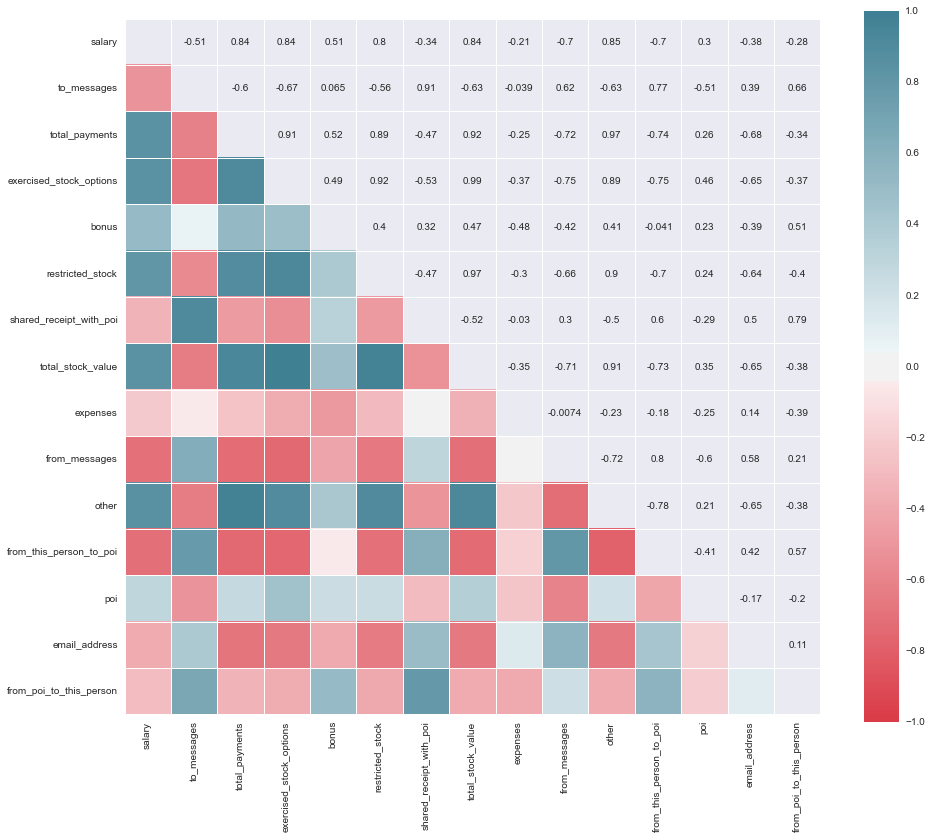

In [354]:
import seaborn as sns
df_salary.corr()
sns.set(style='darkgrid')

f, ax = plt.subplots(figsize=(14, 14))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.corrplot(df_salary.corr(), annot=True, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
f.tight_layout()

In [355]:
df_salary.corr().ix[: ,0] # Pick the first column which we are predicting.

salary                     1.000000
to_messages                0.187047
total_payments             0.579260
exercised_stock_options    0.607324
bonus                      0.523190
restricted_stock           0.550824
shared_receipt_with_poi    0.284995
total_stock_value          0.614736
expenses                   0.145364
from_messages             -0.003541
other                      0.606903
from_this_person_to_poi    0.021288
poi                        0.264976
email_address              0.234134
from_poi_to_this_person    0.179055
Name: salary, dtype: float64

In [440]:
def kcluster_null(df=None, cols=None):
    # Asssert values are passed in. Very lax check here for now.
    #assert df not None, "Please prove a pandas dataframe"
    #assert cols not None, "please provide a list of columns to impute"
    
    # Create a KNN regression estimator for 
    income_imputer = KNeighborsRegressor(n_neighbors=1)
    # Loops through the columns passed in to impute each one sequentially.
    # Ideally these should be somewhat correlated since they will be used in KNN to
    # predict each other, one column at a time.
    for each in cols:
        # Create a temp list that does not include the column being predicted.
        temp_cols = [col for col in cols if col != each]
        # Create a dataframe that contains no missing values in the columns being predicted.
        # This will be used to train the KNN estimator
        df_col = df[df[each].isnull()==False]
        # Create a dataframe with all of the nulls in the column being predicted.
        df_null_col = df[df[each].isnull()==True]
        
        # Create a temp dataframe filling in the medians for each column being used to
        # predict that is missing values.
        # This step is needed since we have so many missing values distributed through 
        # all of the columns.
        temp_df_medians = df_col[temp_cols].apply(lambda x: x.fillna(x.median()), axis=0)
        # Fit our KNN imputer to this dataframe now that we have values for every column.
        income_imputer.fit(temp_df_medians, df_col[each])
        
        # Fill the df (that has null values being predicted) with medians in the other
        # columns not being predicted.
        # ** This currently uses its own medians and should ideally use the predictor df's
        # ** median values to fill in NA's of columns being used to predict.
        temp_null_medians = df_null_col[temp_cols].apply(lambda x: x.fillna(x.median()), axis=0)
        
        # Predict the null values for the current 'each' variable.
        new_values = income_imputer.predict(temp_null_medians[temp_cols])
        # Replace the null values of the original null dataframe with the predicted values.
        df_null_col[each] = new_values
        # Append the new predicted nulls dataframe to the dataframe which containined
        # no null values.
        # Overwrite the original df with this one containing predicted columns. 
        # Index order will not be preserved since it is rearranging each time by 
        # null values.
        df = df_col.append(df_null_col)
    # Returned final dataframe sorted by the index names.
    return df.sort_index(axis=0)

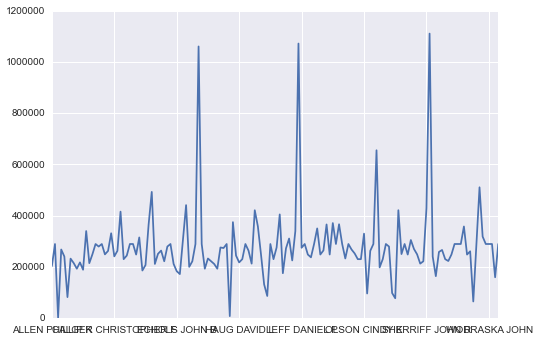

In [447]:
cols = ['salary', 'other', 'total_stock_value', 'exercised_stock_options', 
        'total_payments', 'restricted_stock']

imputed_df = kcluster_null(df_50, cols = cols)
imputed_df.salary.plot()

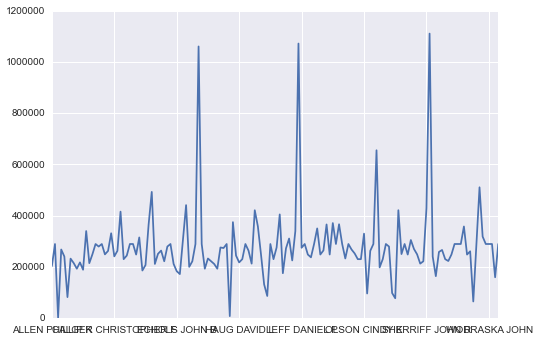

In [448]:
df_50_salary_done.sort_index(axis=0).salary.plot()

In [450]:
# Same values as manually imputing! Yay
len(df_50_salary_done.sort_index(axis=0).salary == imputed_df.salary)

144

In [418]:
# Find some the highest correlated columns to predict salary.
cols = ['other', 'total_stock_value', 'exercised_stock_options', 
        'total_payments', 'restricted_stock']
# Temporarily fill in any missing values in our predictors with the median.
# Medians will be more robust for our skewed data.

## median_imputer = Imputer(missing_values = 'NaN', axis=0)
## median_imputer.fit(df_salary[cols])
## temp_df_medians = median_imputer.transform(df_salary[cols])
#temp_df_medians = df_salary[cols].apply(lambda x: x.fillna(x.median()), axis=0)


df_col_medians = list(df_salary[cols].apply(lambda x: x.median(), axis=0))


income_imputer.fit(temp_df_medians, df_salary.salary)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=1, p=2, weights='uniform')

In [419]:
## temp_null_medians[cols] = median_imputer.transform(df_null_salary[cols])
temp_null_medians = df_null_salary[cols].apply(lambda x: x.fillna(x.median()), axis=0)

new_values = income_imputer.predict(temp_null_medians[cols])

In [420]:
df_null_salary['salary'] = new_values

In [421]:
df_50_salary_done = df_salary.append(df_null_salary)

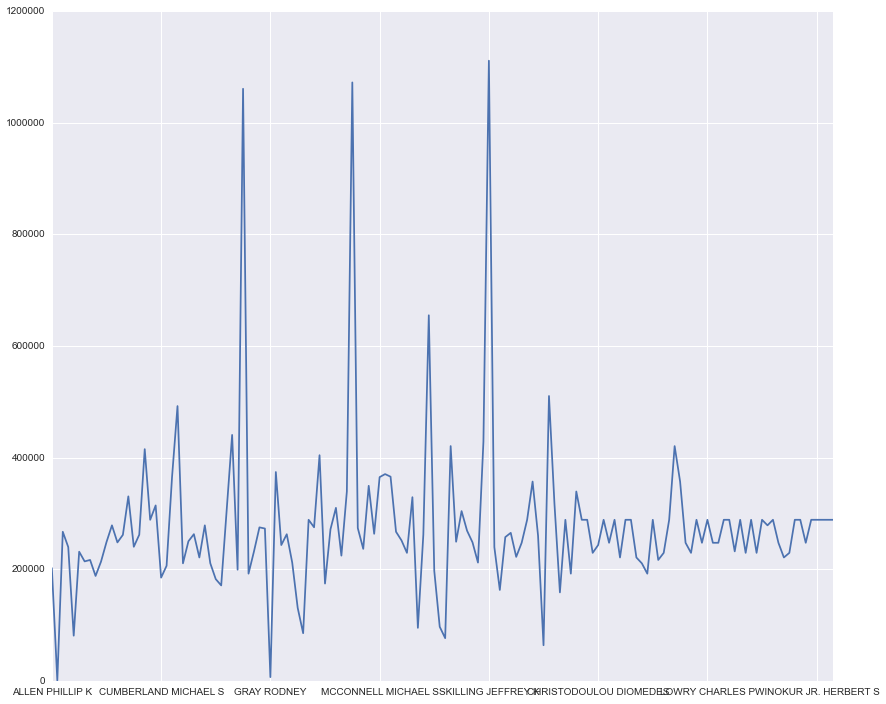

In [422]:
df_50_salary_done.salary.plot(figsize=(14,12), label='kcluster')
#df.salary.fillna(df.salary.median()).plot()
#df.salary.plot(label='missing')


In [390]:
df_50_salary_done.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 15 columns):
salary                     144 non-null float64
to_messages                86 non-null float64
total_payments             124 non-null float64
exercised_stock_options    101 non-null float64
bonus                      81 non-null float64
restricted_stock           109 non-null float64
shared_receipt_with_poi    86 non-null float64
total_stock_value          125 non-null float64
expenses                   94 non-null float64
from_messages              86 non-null float64
other                      92 non-null float64
from_this_person_to_poi    86 non-null float64
poi                        144 non-null bool
email_address              144 non-null bool
from_poi_to_this_person    86 non-null float64
dtypes: bool(2), float64(13)

In [451]:
df_50_salary_done.salary.nunique()

93

In [453]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 15 columns):
salary                     144 non-null float64
to_messages                86 non-null float64
total_payments             144 non-null float64
exercised_stock_options    144 non-null float64
bonus                      81 non-null float64
restricted_stock           144 non-null float64
shared_receipt_with_poi    86 non-null float64
total_stock_value          144 non-null float64
expenses                   94 non-null float64
from_messages              86 non-null float64
other                      144 non-null float64
from_this_person_to_poi    86 non-null float64
poi                        144 non-null bool
email_address              144 non-null bool
from_poi_to_this_person    86 non-null float64
dtypes: bool(2), float64(13)

In [493]:
df_50 = df_50.apply(lambda x: x.fillna(0), axis=0)

df_50['total_adj_compensation'] = df_50['salary'] + df_50['bonus'] + \
df_50['expenses'] + df_50['restricted_stock'] + df_50['other'] + \
df_50['exercised_stock_options']



df_50[['poi', 'total_adj_compensation']].sort('total_adj_compensation', ascending = False).head(50)

,poi,total_adj_compensation
LAY KENNETH L,True,67641960
SKILLING JEFFREY K,True,32856388
HIRKO JOSEPH,True,30846898
PAI LOU L,False,26941313
FREVERT MARK A,False,25197725
RICE KENNETH D,True,24934964
WHITE JR THOMAS E,False,17078482
BAXTER JOHN C,False,14761863
LAVORATO JOHN J,False,13557521
YEAGER F SCOTT,True,12245058


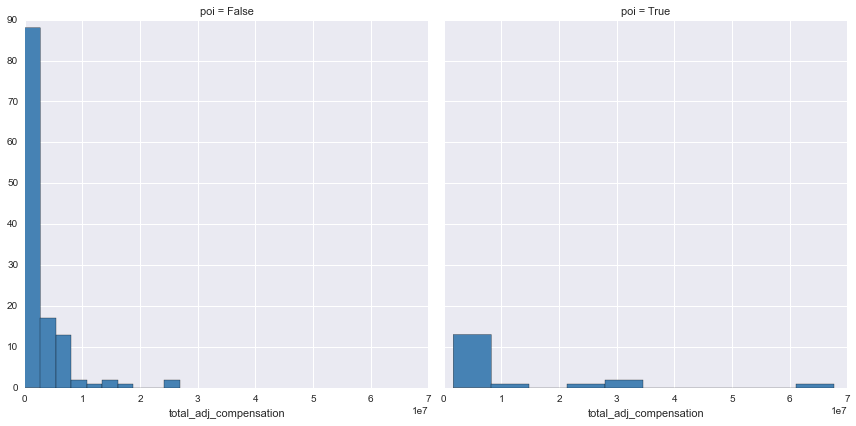

In [486]:
g = sns.FacetGrid(df_50, col='poi', margin_titles=True, size=6)
g.map(plt.hist, 'total_adj_compensation', color='steelblue')

## Remove columns with less than 50% of entries present.
## Remove rows with no non-NA values

In [291]:
low_var_remover = VarianceThreshold(threshold=.5)

In [336]:
# Remove columns with more than 50% NA's
df_50 = df.dropna(axis=1, thresh=len(df)/2)
# Since email_address and poi are True/False, every record should have at least 2 non-NA.
# We'll next remove any rows that don't have at least 3 non-NA values.
# This will only remove records that are completely blank except for poi/email_address.
df_50 = df_50.dropna(axis=0, thresh=3)
# One record was removed
df_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 15 columns):
salary                     94 non-null float64
to_messages                86 non-null float64
total_payments             124 non-null float64
exercised_stock_options    101 non-null float64
bonus                      81 non-null float64
restricted_stock           109 non-null float64
shared_receipt_with_poi    86 non-null float64
total_stock_value          125 non-null float64
expenses                   94 non-null float64
from_messages              86 non-null float64
other                      92 non-null float64
from_this_person_to_poi    86 non-null float64
poi                        144 non-null bool
email_address              144 non-null bool
from_poi_to_this_person    86 non-null float64
dtypes: bool(2), float64(13)

In [337]:
pd.value_counts(df_50.poi)

False    126
True      18
dtype: int64

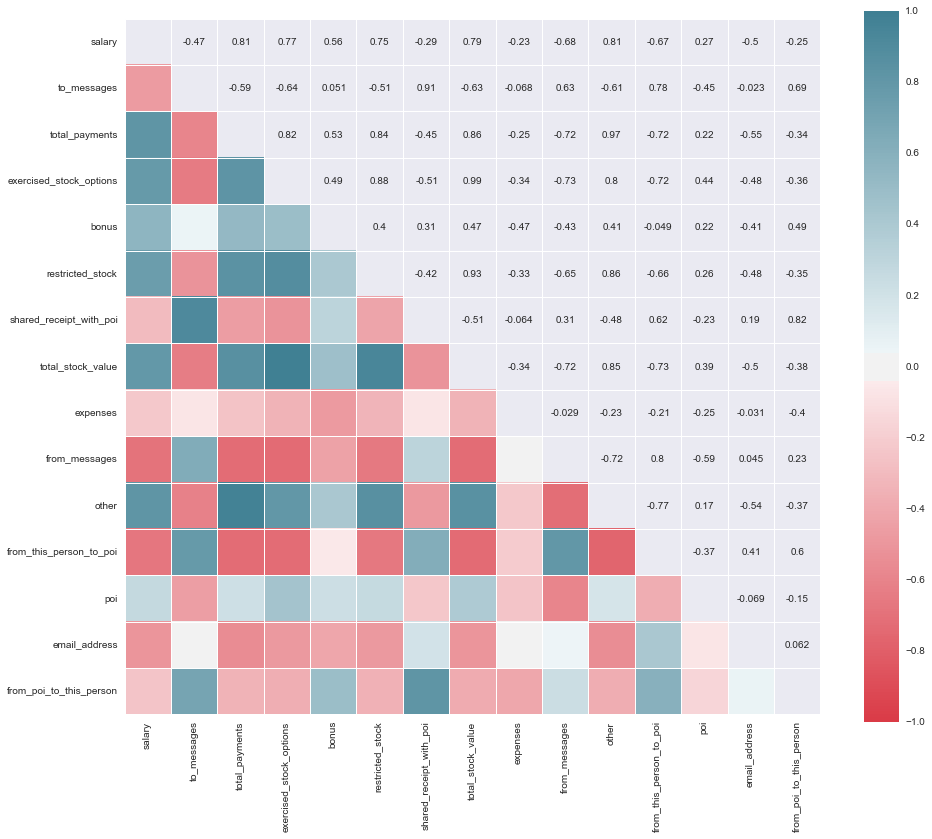

In [455]:
imputed_df.corr()
sns.set(style='darkgrid')

f, ax = plt.subplots(figsize=(14, 14))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.corrplot(imputed_df.corr(), annot=True, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
f.tight_layout()

In [300]:
help(df.dropna)

Help on method dropna in module pandas.core.frame:

dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False) method of pandas.core.frame.DataFrame instance
    Return object with labels on given axis omitted where alternately any
    or all of the data are missing
    
    Parameters
    ----------
    axis : {0, 1}, or tuple/list thereof
        Pass tuple or list to drop on multiple axes
    how : {'any', 'all'}
        * any : if any NA values are present, drop that label
        * all : if all values are NA, drop that label
    thresh : int, default None
        int value : require that many non-NA values
    subset : array-like
        Labels along other axis to consider, e.g. if you are dropping rows
        these would be a list of columns to include
    inplace : boolean, defalt False
        If True, do operation inplace and return None.
    
    Returns
    -------
    dropped : DataFrame



## Feature Importances

In [186]:
## Add features
df2 = df.copy()
df2 = df2.apply(lambda x: x.fillna(x.median()), axis=0)
df2['EXERCISE_SALARY'] = df2['exercised_stock_options']/df2['salary']
df2['LOG_EX_STOCK_OPT'] = df2['exercised_stock_options']
df2['DEFFERED_STOCK'] = df2['deferred_income']/df2['total_stock_value']
df2['EXERCISE_TOTAL_STOCK'] = df2['exercised_stock_options']/df2['total_stock_value']
df2['EXERCISE_DEFFERED'] = df2['exercised_stock_options']/df2['deferred_income']
#df2['TWO_FROM'] = df2['from_poi_to_this_person']/df2['from_this_person_to_poi']
X_df = df2.drop('poi', axis=1)
y_df = df2['poi']

In [222]:

#print X_noNA
rf = ExtraTreesClassifier(n_estimators=2000, min_samples_split=4, 
                          max_features=None, min_samples_leaf=1)
rf.fit(X_df, y_df)
rf.feature_importances_

array([  1.87941663e-02,   1.77841193e-02,   2.03552876e-02,
         2.91209831e-02,   9.39857160e-02,   5.05642266e-02,
         3.34005427e-02,   5.80753065e-02,   2.86125730e-03,
         5.41747300e-02,   5.87527473e-02,   1.84430721e-04,
         1.63960459e-02,   5.01092647e-02,   6.31635285e-02,
         6.44387166e-06,   7.74600005e-02,   4.55756682e-02,
         6.67689742e-03,   2.86507662e-02,   9.11663567e-02,
         1.27086049e-02,   9.36818482e-02,   4.17423414e-02,
         3.46087200e-02])

In [223]:
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

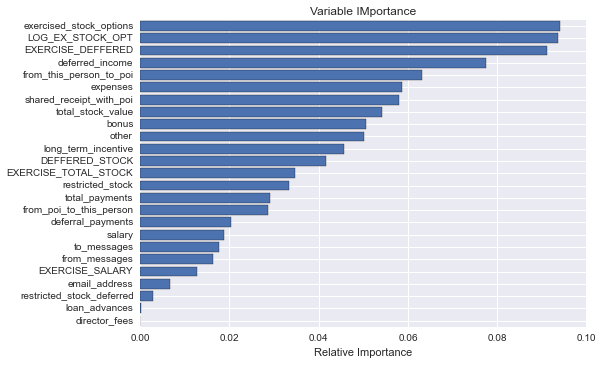

In [224]:
padding = np.arange(len(X_df.columns)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, X_df.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable IMportance")
plt.show()

# http://nbviewer.ipython.org/github/yhat/DataGotham2013/blob/master/notebooks/7%20-%20Feature%20Engineering.ipynb


In [225]:
pd.crosstab(df.poi, df.email_address)

email_address,False,True
poi,,
False,34,93
True,0,18


## Test New Methods

In [ ]:
from sklearn.svm import LinearSVC
sk_fold = StratifiedShuffleSplit(y_df, n_iter=10, test_size=0.2) 
        
pipeline = Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)),
                           ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)),
                           ('low_var_remover', VarianceThreshold(threshold=0.1)), 
                           ('feature_selection', LinearSVC()),
                           ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,
                                                       criterion='gini', n_estimators=1500, n_jobs=1,
                                                       oob_score=True, random_state=None, verbose=0,
                                                       max_features='auto', min_samples_split=2,
                                                       min_samples_leaf=1))])
    
params = {'ET__n_estimators': [1500],
          'ET__max_features': ['auto', None],
          'ET__min_samples_split': [2, 4, 10],
          'ET__min_samples_leaf': [1, 2, 5],
          'feature_selection__C': [1, 10, 100],
          #'ET__criterion' : ['gini', 'entropy'],
          #'imputer__strategy': ['median', 'mean'],
          'low_var_remover': [0, 0.1, .25, .50]}
    
grid_search = GridSearchCV(pipeline, param_grid=params, cv=sk_fold, n_jobs = -1, scoring='f1')
grid_search.fit(X_df, y=y_df)
#test_pred = grid_search.predict(X_test)
#print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
print "Best Estimator: ", grid_search.best_estimator_
    #f1_avg.append(f1_score(y_test, test_pred))
#print "F1: ", f1_score(y_test, test_pred)
#print "Confusion Matrix: "
#print confusion_matrix(y_test, test_pred)
#print "Accuracy Score: ", accuracy_score(y_test, test_pred)
print "Best Params: ", grid_search.best_params_

In [ ]:
n_iter = 100
sk_fold = StratifiedShuffleSplit(y_df, n_iter=n_iter, test_size=0.1)
f1_avg = []
for train_index, test_index in sk_fold:
    X_train, X_test = X_df.irow(train_index), X_df.irow(test_index)
    y_train, y_test = y_df[train_index], y_df[test_index]

    grid_search.best_estimator_.fit(X_train, y=y_train)
    test_pred = grid_search.predict(X_test)
    #print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
    #print "Best Estimator: ", grid_search.best_estimator_
    #print f1_score(y_test, test_pred)
    f1_avg.append(f1_score(y_test, test_pred))
print sum(f1_avg)/n_iter

## Just pipeline

In [20]:
pipeline = Pipeline([
    ('imputer', Imputer(missing_values = 'NaN', axis=0)),
    ('standardizer', StandardScaler(with_mean=True, with_std=True)),
    ('low_var_remover', VarianceThreshold(threshold=.10)),
    # ('pca', PCA()),
    ('ET', ExtraTreesClassifier(oob_score=True, bootstrap=True) )
])
    
params = {'ET__n_estimators': [500],
          'ET__max_features': ['auto', None, 3, 5, 10, 15],
          'ET__min_samples_split': [2, 4, 10],
          'ET__min_samples_leaf': [1, 2, 5],
          'ET__criterion' : ['gini', 'entropy'],
          'imputer__strategy': ['median', 'mean']}
    
grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs = -1, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y=y_train)
test_pred = grid_search.predict(X_test)
#print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
print "Best Estimator: ", grid_search.best_estimator_
print "F1: ", f1_score(y_test, test_pred)
print "Confusion Matrix: "
print confusion_matrix(y_test, test_pred)
print "Accuracy Score: ", accuracy_score(y_test, test_pred)
print "Best Params: ", grid_search.best_params_
print ""

[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 634 out of 648 | elapsed:   48.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   49.5s finished


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,
 ...ples_split=2, n_estimators=500, n_jobs=1, oob_score=True,
           random_state=None, verbose=0))])
F1:  0.285714285714
Confusion Matrix: 
[[42  0]
 [ 5  1]]
Accuracy Score:  0.895833333333
Best Params:  {'ET__n_estimators': 500, 'ET__criterion': 'gini', 'ET__max_features': 15, 'imputer__strategy': 'mean', 'ET__min_samples_split': 2, 'ET__min_samples_leaf': 1}



In [ ]:
# Logistic Regression Baseline

In [55]:
from sklearn.linear_model import LogisticRegression

sk_fold = StratifiedKFold(y_df, n_folds=4, shuffle=True)
for train_index, test_index in sk_fold:
    X_train, X_test = X_df.irow(train_index), X_df.irow(test_index)
    y_train, y_test = y_df[train_index], y_df[test_index]
    
    pipeline = Pipeline([
      ('imputer', Imputer(missing_values = 'NaN', strategy='median', axis=0)),
      ('standardizer', StandardScaler(with_mean=True, with_std=True)),
      ('low_var_remover', VarianceThreshold(threshold=.10)),
      ('LR', LogisticRegression() )
    ])
    
    params = {'LR__C': [.01, 1, 10]}
    
    grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs = -1, cv=None, scoring='f1')
    grid_search.fit(X_train, y=y_train)
    test_pred = grid_search.predict(X_test)
    #print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
    print "Best Estimator: ", grid_search.best_estimator_
    print "F1: ", f1_score(y_test, test_pred)
    print "Confusion Matrix: "
    print confusion_matrix(y_test, test_pred)
    print "Accuracy Score: ", accuracy_score(y_test, test_pred)
    print "Best Params: ", grid_search.best_params_
    print ""

Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('LR', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001))])
F1:  0.285714285714
Confusion Matrix: 
[[31  1]
 [ 4  1]]
Accuracy Score:  0.864864864865
Best Params:  {'LR__C': 0.01}

Best Estimator:  Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('LR', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001))])
F1:  0.333333333333
Confusion Matrix:

In [54]:
## Baseline braindead scores for returning the highest frequency 0 as a guess.

{'LR__C': 1}

In [40]:

sk_fold = StratifiedKFold(y_df, n_folds=4, shuffle=True)
for train_index, test_index in sk_fold:
    X_train, X_test = X_df.irow(train_index), X_df.irow(test_index)
    y_train, y_test = y_df[train_index], y_df[test_index]
    
    test_pred = np.zeros(y_test.shape)
    print "F1: ", f1_score(y_test, test_pred)
    print "Confusion Matrix: "
    print confusion_matrix(y_test, test_pred)
    print "Accuracy Score: ", accuracy_score(y_test, test_pred)
    print ""

F1:  0.0
Confusion Matrix: 
[[32  0]
 [ 5  0]]
Accuracy Score:  0.864864864865

F1:  0.0
Confusion Matrix: 
[[32  0]
 [ 5  0]]
Accuracy Score:  0.864864864865

F1:  0.0
Confusion Matrix: 
[[32  0]
 [ 4  0]]
Accuracy Score:  0.888888888889

F1:  0.0
Confusion Matrix: 
[[31  0]
 [ 4  0]]
Accuracy Score:  0.885714285714

